In [3]:
import pandas as pd
import numpy as np
from sklearn import cross_validation, metrics   
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import operator 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier 
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
trainData = pd.read_csv('1e7data_train.csv', index_col=0)
testData = pd.read_csv('1e7data_holdout.csv', index_col=0)
df = trainData
dftest = testData

feature_names = ['daOverRH1', 'daOverRH2', 'mindaOverRH', 'maxdaOverRH','norm_std_a1',
                 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1',
                'norm_std_a2', 'norm_std_window10_a2', 'norm_max_window10_a2', 'norm_max_a2',
                'norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3', 
                'avg_ecross1', 'std_ecross1', 'min_ecross1', 'max_ecross1', 
                'avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2',
                'avg_ecross3', 'max_ecross3', 'min_ecross3', 'std_ecross3', 
                'norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope', 'norm_LyapunovTime']

X_train = df[feature_names]


y_train = df['Stable']
X_test = dftest[feature_names]

X_train = X_train.replace(np.nan, -999)
X_train = X_train.replace(np.inf, -999)

X_test = X_test.replace(np.nan, -999)
X_test = X_test.replace(np.inf, -999)





In [4]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(loss='deviance', learning_rate=0.002, n_estimators=5000,
                                  subsample=.5,  min_samples_split=2, 
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=8,
                                  init=None, random_state=42, 
                                  max_leaf_nodes=8, warm_start=False, max_features=.5)

model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.002, loss='deviance', max_depth=8,
              max_features=0.5, max_leaf_nodes=8, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5000,
              presort='auto', random_state=42, subsample=0.5, verbose=0,
              warm_start=False)

In [5]:
vals = model.feature_importances_*100000

val_dict = dict(zip(feature_names, vals))
sorted_vals = sorted(val_dict.items(), key = operator.itemgetter(1))

feature_names_sorted = []
for scores in sorted_vals: 
    feature_names_sorted.append(scores[0])

vals_sorted = sorted(vals)

print feature_names_sorted
print vals_sorted

['norm_a1_slope', 'norm_a3_slope', 'norm_a2_slope', 'max_ecross1', 'avg_ecross1', 'std_ecross1', 'std_ecross3', 'norm_max_window10_a1', 'min_ecross1', 'std_ecross2', 'norm_std_window10_a1', 'avg_ecross2', 'avg_ecross3', 'norm_std_window10_a3', 'norm_max_window10_a2', 'norm_std_a1', 'max_ecross3', 'norm_max_window10_a3', 'norm_std_window10_a2', 'norm_max_a3', 'norm_max_a1', 'min_ecross3', 'min_ecross2', 'max_ecross2', 'daOverRH1', 'norm_std_a3', 'norm_LyapunovTime', 'daOverRH2', 'maxdaOverRH', 'mindaOverRH', 'norm_std_a2', 'norm_max_a2']
[0.0, 0.0, 0.0, 1408.9783433470543, 1633.8556145440327, 1681.543825632473, 1735.6670806441939, 1924.2259330760403, 1963.7884348183479, 2109.1953734798994, 2275.0438540643554, 2367.5596185718141, 2385.9650580432408, 2392.8819831655219, 2467.1335086460576, 2562.9315171908756, 2583.2575836432179, 2637.0652790748181, 2755.4615025760454, 2860.5866924835004, 3007.8094736728513, 3519.7677250444649, 3635.8428769408006, 3782.4744842025007, 3883.2898781438994, 41

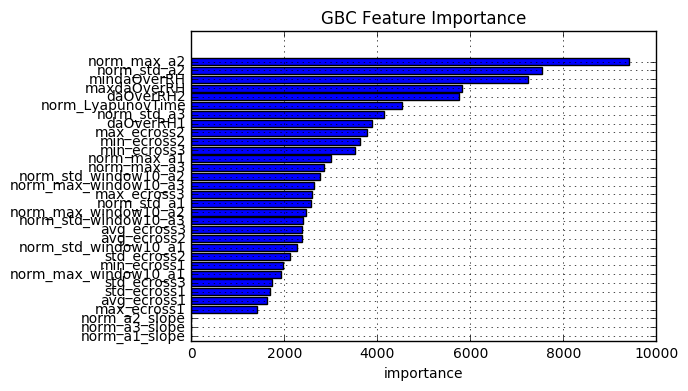

In [9]:
from pylab import *


points = vals_sorted

pos = arange(len(vals_sorted)) + .5 # centres the graph along y 

figure(1) # gives the figure a placeholder in memory
barh(pos, vals_sorted, align='center') 
yticks(pos, feature_names_sorted)
xlabel('importance')
title('GBC Feature Importance')
grid(True)
show()

In [20]:
import itertools

vals = model.feature_importances_*100000

val_dict = dict(zip(feature_names, vals))
sorted_vals = sorted(val_dict.items(), key = operator.itemgetter(1), reverse=True)

feature_names_sorted = []
for scores in sorted_vals: 
    feature_names_sorted.append(scores[0])

vals_sorted = sorted(vals, reverse=True)

top_10_names = feature_names_sorted[:9]
top_10_vals = vals_sorted[:9]

print top_10_names
print top_10_vals

['norm_max_a2', 'norm_std_a2', 'mindaOverRH', 'maxdaOverRH', 'daOverRH2', 'norm_LyapunovTime', 'norm_std_a3', 'daOverRH1', 'max_ecross2']
[9419.7089379845893, 7533.3229477057575, 7228.600020380617, 5826.0347101719572, 5759.0634522493774, 4528.2009110167883, 4130.7433794849076, 3883.2898781438994, 3782.4744842025007]


In [34]:
%matplotlib nbagg    
# %matplotlib notebook

# another method
from sklearn.ensemble.partial_dependence import partial_dependence
from mpl_toolkits.mplot3d import Axes3D

def D3_pdp(target_feature, model, X_train, names_list):
    fig = plt.figure()

    pdp, axes = partial_dependence(model, target_variables=target_feature, X=X_train, 
                                   grid_resolution=50, proba=True)
    XX, YY = np.meshgrid(axes[0], axes[1])
    Z = pdp[0].reshape(list(map(np.size, axes))).T
    ax = Axes3D(fig)
    surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
    ax.set_xlabel(feature_names_sorted[target_feature[0]])
    ax.set_ylabel(feature_names_sorted[target_feature[1]])
    ax.set_zlabel('Partial dependence')
    #  pretty init view
    ax.view_init(elev=22, azim=122)
    plt.colorbar(surf)
    plt.suptitle('Partial dependence of stability on {0} and {1} '.format(names_list[target_feature[0]], names_list[target_feature[1]]))
    plt.subplots_adjust(top=0.9)

    plt.show()

In [35]:
comb =  list(itertools.combinations(range(0, 10), 2))

print comb

print len(comb)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)]
45


<IPython.core.display.Javascript object>


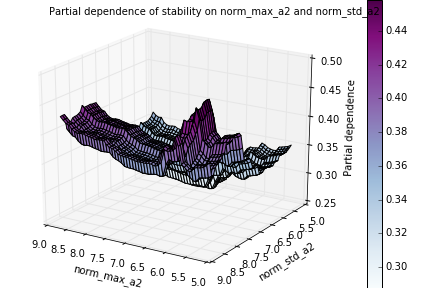

<IPython.core.display.Javascript object>


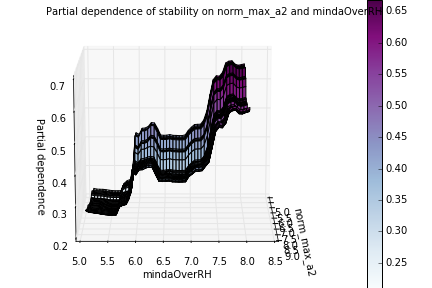

<IPython.core.display.Javascript object>


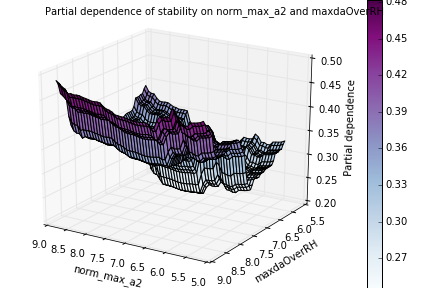

<IPython.core.display.Javascript object>


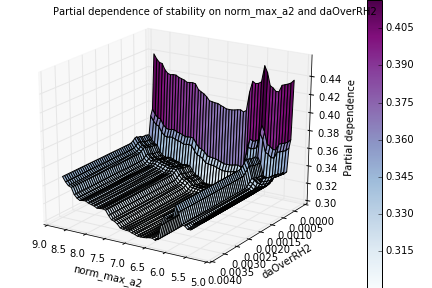

<IPython.core.display.Javascript object>


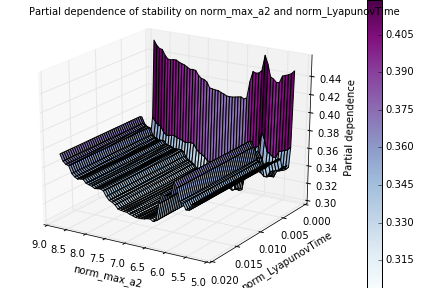

<IPython.core.display.Javascript object>


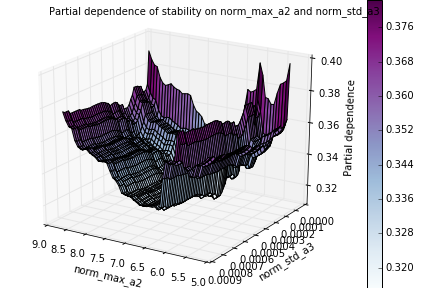

<IPython.core.display.Javascript object>


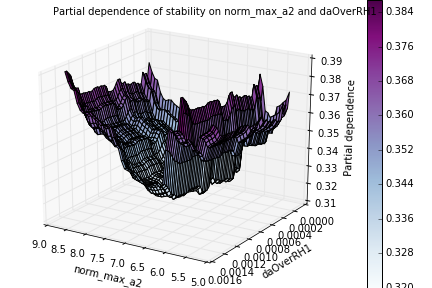

<IPython.core.display.Javascript object>


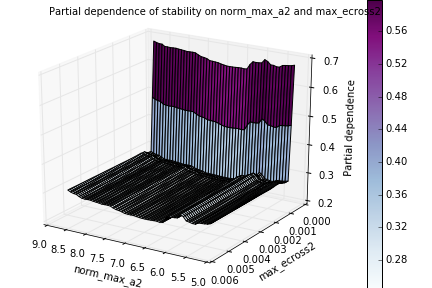

<IPython.core.display.Javascript object>


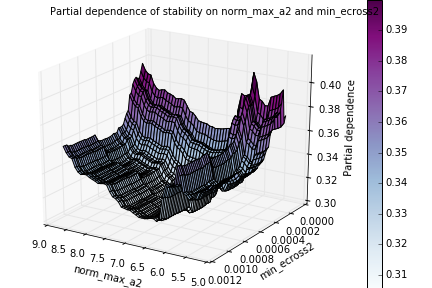

<IPython.core.display.Javascript object>


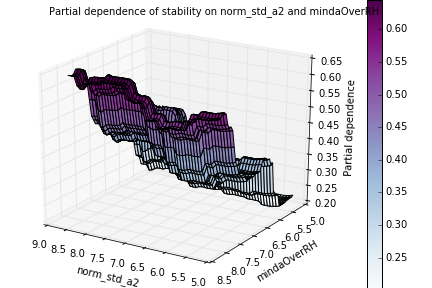

<IPython.core.display.Javascript object>


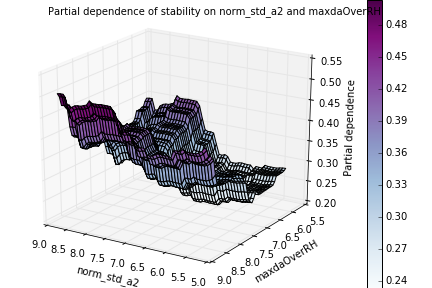

<IPython.core.display.Javascript object>


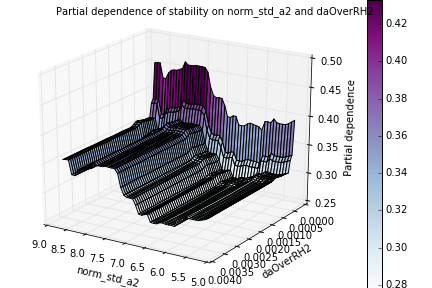

<IPython.core.display.Javascript object>


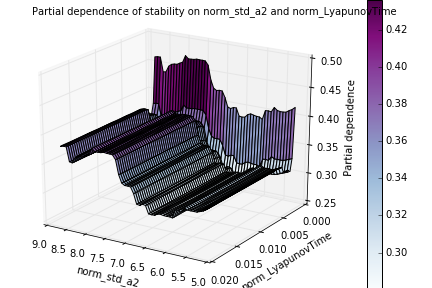

<IPython.core.display.Javascript object>


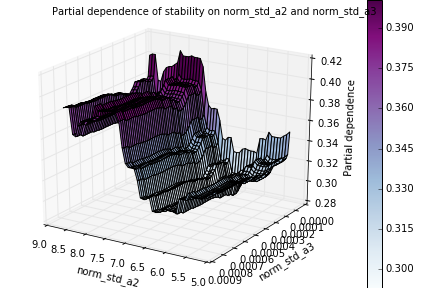

<IPython.core.display.Javascript object>


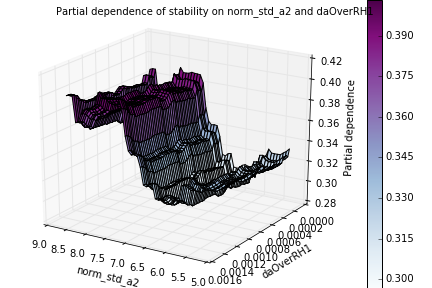

<IPython.core.display.Javascript object>


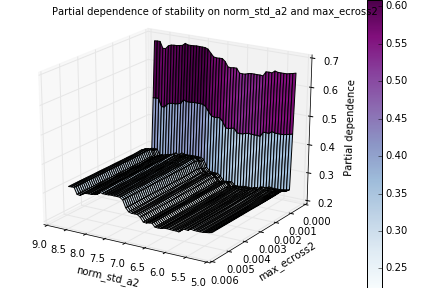

<IPython.core.display.Javascript object>


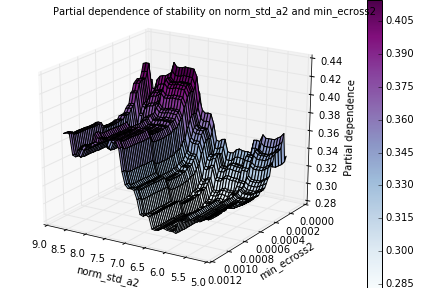

<IPython.core.display.Javascript object>


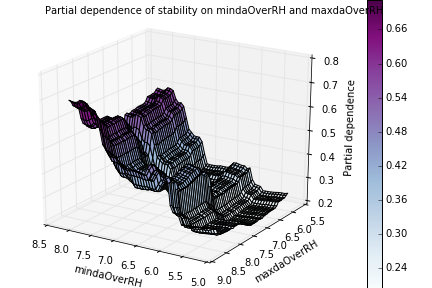

<IPython.core.display.Javascript object>


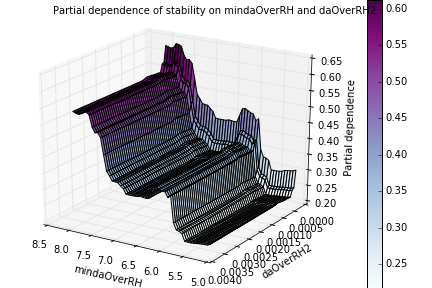

<IPython.core.display.Javascript object>


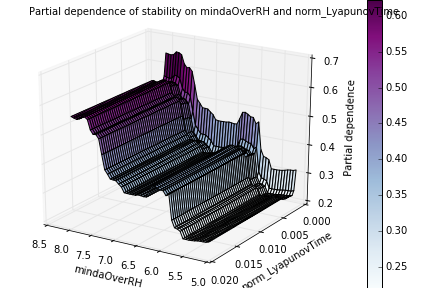

<IPython.core.display.Javascript object>


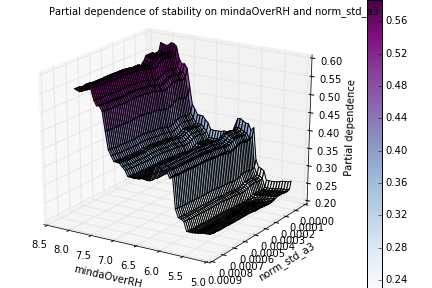

<IPython.core.display.Javascript object>


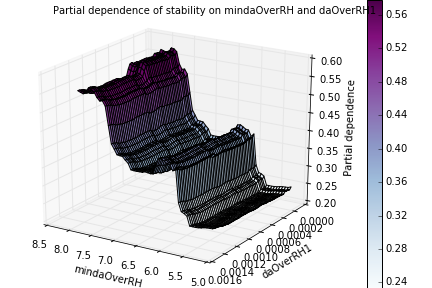

<IPython.core.display.Javascript object>


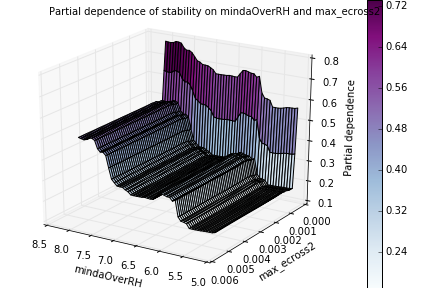

<IPython.core.display.Javascript object>


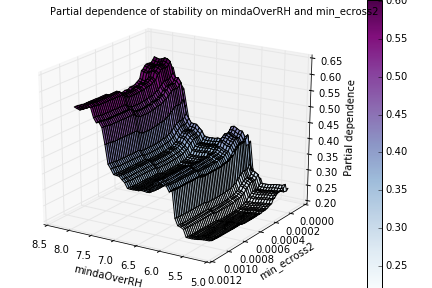

<IPython.core.display.Javascript object>


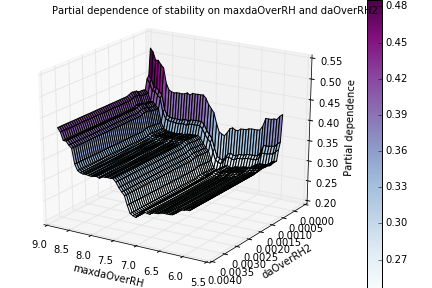

<IPython.core.display.Javascript object>


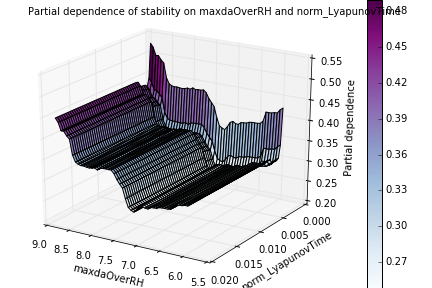

<IPython.core.display.Javascript object>


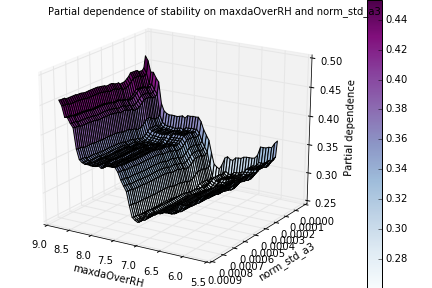

<IPython.core.display.Javascript object>


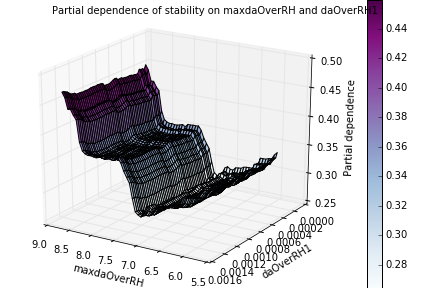

<IPython.core.display.Javascript object>


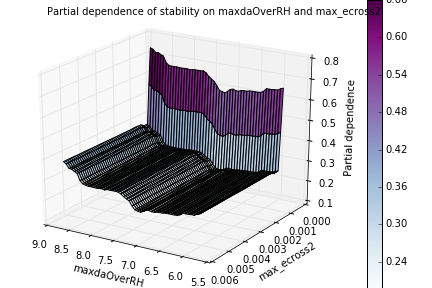

<IPython.core.display.Javascript object>


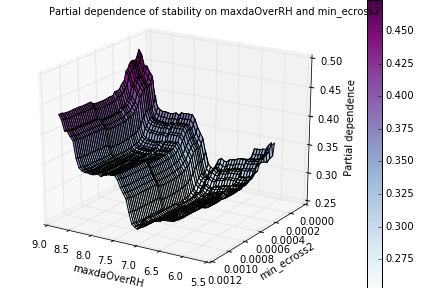

<IPython.core.display.Javascript object>


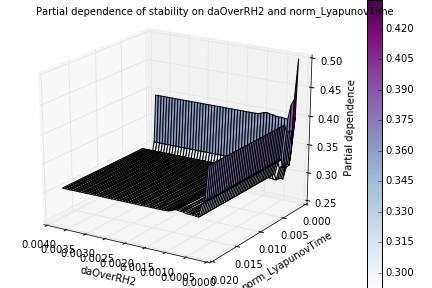

<IPython.core.display.Javascript object>


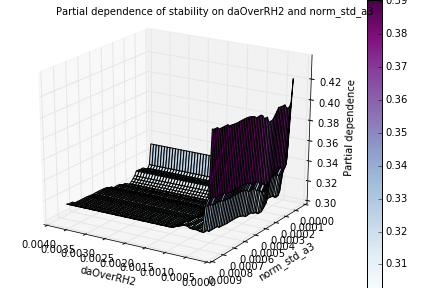

<IPython.core.display.Javascript object>


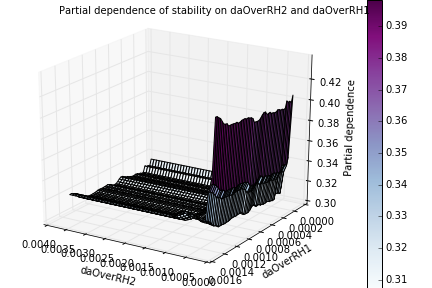

<IPython.core.display.Javascript object>


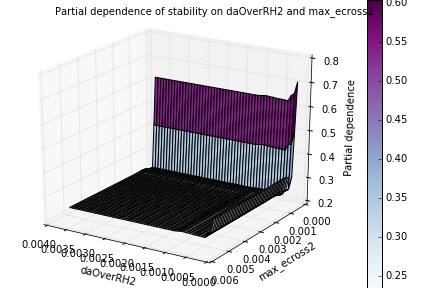

<IPython.core.display.Javascript object>


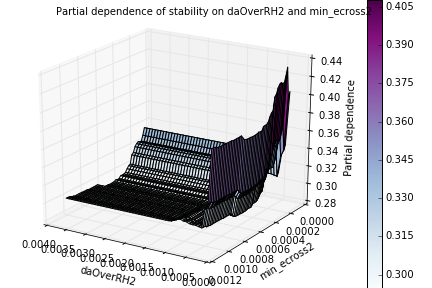

<IPython.core.display.Javascript object>


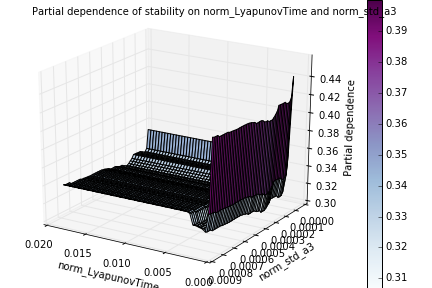

<IPython.core.display.Javascript object>


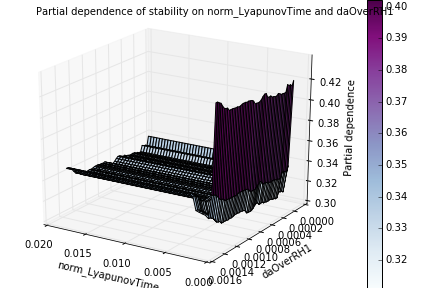

<IPython.core.display.Javascript object>


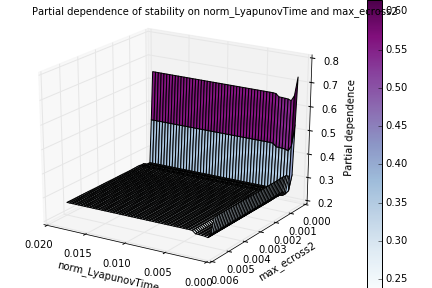

<IPython.core.display.Javascript object>


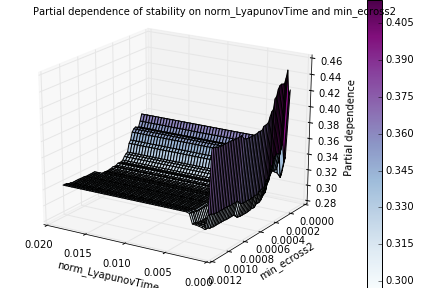

<IPython.core.display.Javascript object>


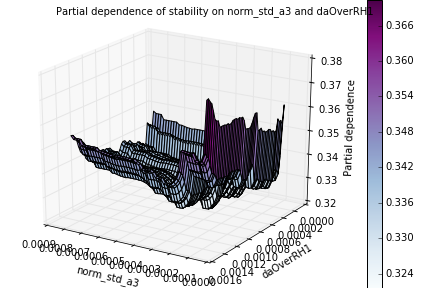

<IPython.core.display.Javascript object>


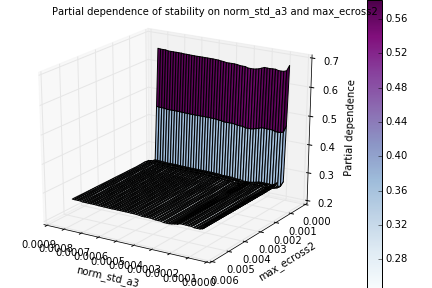

<IPython.core.display.Javascript object>


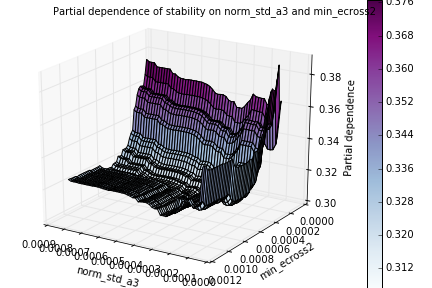

<IPython.core.display.Javascript object>


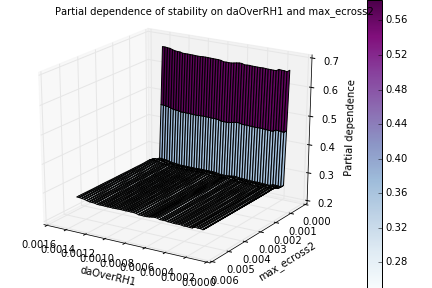

<IPython.core.display.Javascript object>


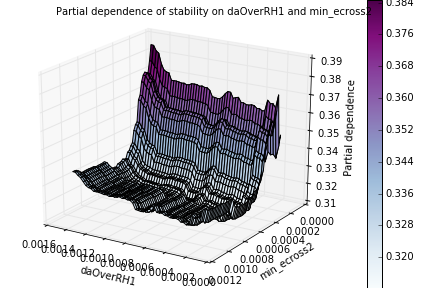

<IPython.core.display.Javascript object>


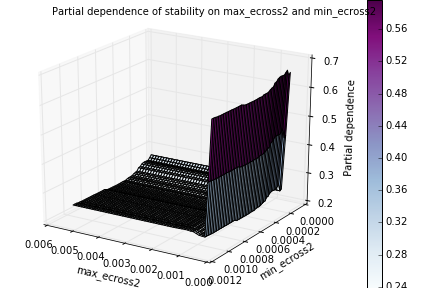

In [36]:
for pairs in comb: 
    D3_pdp(pairs, model, X_train, feature_names_sorted)
    